In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import boxcox1p
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,TransformerMixin,RegressorMixin
from numpy import polyfit
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import warnings
warnings.filterwarnings('ignore')

In [79]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """This class is a dataframe selector.
    Data members:
        features: A list of column_names you want in output dataframe
    """

    def __init__(self, features):
        self.features = features

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        features = self.features
        return X[self.features]


class DatetimeTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X["desembolso"] = pd.to_datetime(X["desembolso"], format="%Y-%m-%d")
        X["vencimento"] = pd.to_datetime(X["vencimento"], format="%Y-%m-%d")
        
        X["duracao_esperada"] = (X["vencimento"] - X["desembolso"]).dt.days
        X['desembolso_mes'] = X['desembolso'].dt.month
        X['desembolso_ano'] = X['desembolso'].dt.year
        X['vencimento_mes'] = X['vencimento'].dt.month
        X['vencimento_ano'] = X['vencimento'].dt.year
        
        X.drop(columns=["desembolso", "vencimento", "dia"], inplace=True)
        
        return X


class TimeseriesNormalization(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Getting the numpy array to improve performance
        attributes = [
            "id",
            "valor_emprestado",
            "divida_total",
            "divida_principal",
            "pagamento_diario",
            "amortizacao_principal_diario",
            "transacionado",
        ]

        array = X[attributes].values
        unique_ids = np.unique(array[:, 0])

        # this loop takes approx. 1.5 min to run
        for loan_index in unique_ids:
            id_rows = loan_index == array[:, 0]

            # get array relative to the id
            tmp_array = array[id_rows, :]
            loan_value = tmp_array[0, 1]

            tmp_array[:, 2:] /= loan_value

            array[id_rows, 2:] = tmp_array[:, 2:]

        df = pd.DataFrame(array, columns=attributes)
        X.loc[:,attributes] = df
        X['id'] = X['id'].astype(int)
        
        return X


class Aggregator(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Extracting a DataFrame with constant attributes        
        id_attribute = ["id"]

        constant_attributes = [
            "desembolso_mes",
            "desembolso_ano",
            "vencimento_mes",
            "vencimento_ano",
            "valor_emprestado",
            "pgto_diario_esperado",
            "duracao_esperada",
        ]
        
        new_attributes = [
            "pagamento_diario_total",
            "amortizacao_diario_total",
            "transacao_diaria_total",
            "divida_total_menos_principal_area",
            "divida_total_variacao",
            "coef_fittado_decaimento_divida",
            "score_do_fit",
        ]

        timeseries_attributes = [
            "pagamento_diario",
            "amortizacao_principal_diario",
            "transacionado",
            "divida_total",
            "divida_principal",
            "dias_pos_desembolso",
        ]
        
        id_identifier = X[id_attribute].values.flatten()
        array_numeric = X[constant_attributes + timeseries_attributes].values
        unique_ids = np.unique(id_identifier)

        df_array_num = np.zeros(
            (len(unique_ids), len(constant_attributes + new_attributes))
        )
        
        for i, unique_id in enumerate(unique_ids):

            id_rows = id_identifier == unique_id
            tmp_arr_num = array_numeric[id_rows, :]
            
            #if loan has only one row it is duplicated
            if id_rows.sum() == 1:
                tmp_arr_num = np.r_[tmp_arr_num, tmp_arr_num]
                tmp_arr_num[1,12] = tmp_arr_num[0,12] + 1
                

            # getting constant attributes
            desembolso_mes = tmp_arr_num[0, 0]
            desembolso_ano = tmp_arr_num[0, 1]
            vencimento_mes = tmp_arr_num[0, 2]
            vencimento_ano = tmp_arr_num[0, 3]
            valor_emprestado = tmp_arr_num[0, 4]
            pgto_diario_esperado = tmp_arr_num[-1, 5]
            duracao_esperada = tmp_arr_num[-1, 6]


            # getting timeseries attributes
            pagamento_diario = tmp_arr_num[:, 7]
            amortizacao_principal_diario = tmp_arr_num[:, 8]
            transacionado = tmp_arr_num[:, 9]
            divida_total = tmp_arr_num[:, 10]
            divida_principal = tmp_arr_num[:, 11]
            dias_pos_desembolso = tmp_arr_num[:, 12]

            tmp_summed_daily_payment = sum(pagamento_diario)
            tmp_summed_daily_amortization = sum(amortizacao_principal_diario)
            tmp_summed_daily_transaction = sum(transacionado)

            tmp_total_minus_main_debt_area = np.trapz(
                divida_total - divida_principal)

            # if positive the debt decrease
            tmp_total_debt_variation = divida_total[0] - divida_total[-1]
            
            y = divida_total * 100
            X = dias_pos_desembolso
            fit, tmp_linear_regression_score, _, _, _ = polyfit(
                X, y, deg=1, full=True)
            if tmp_linear_regression_score.size == 0:
                tmp_linear_regression_score = 0

            tmp_fitted_coef_of_debt_payment = -1 * fit[0]

            df_array_num[i, :] = [
                desembolso_mes,
                desembolso_ano,
                vencimento_mes,
                vencimento_ano,
                valor_emprestado,
                pgto_diario_esperado,
                duracao_esperada,
                tmp_summed_daily_payment,
                tmp_summed_daily_amortization,
                tmp_summed_daily_transaction,
                tmp_total_minus_main_debt_area,
                tmp_total_debt_variation,
                tmp_fitted_coef_of_debt_payment,
                tmp_linear_regression_score,
            ]
            
        df = pd.DataFrame(
            index=unique_ids,
            columns=constant_attributes + new_attributes,
            data=df_array_num,
        )

        return df


class Binning(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        
        X['duracao_esperada'] = X['duracao_esperada'].apply(lambda duration: '0-340 days' if duration <= 340 else '340+ days')        
        X['desembolso_ano'] = X['desembolso_ano'].apply(lambda year: 'desembolso_2020+' if year >=2020 else 'desembolso_2019-' )
        X['vencimento_ano'] = X['vencimento_ano'].apply(lambda year: 'vencimento_2021+' if year >=2021 else 'vencimento_2020-')
        
        dtypes = {
            'duracao_esperada': 'category',
            'desembolso_ano': 'category',
            'vencimento_ano': 'category'
        }

        X = X.astype(dtypes)
        
        X['pagamento_diario_total'] = pd.qcut(X['pagamento_diario_total'], np.linspace(0,1, 3))
        X['amortizacao_diario_total'] = pd.qcut(X['amortizacao_diario_total'], np.linspace(0,1, 4))
        X['transacao_diaria_total'] = pd.qcut(X['transacao_diaria_total'], np.linspace(0,1, 5))
        X['divida_total_menos_principal_area'] = pd.qcut(X['divida_total_menos_principal_area'], np.linspace(0,1, 2))
        X['divida_total_variacao'] = pd.qcut(X['divida_total_variacao'], np.linspace(0,1, 3))

        global tmp_df
        tmp_df = X
        return X


class PowerTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['valor_emprestado'] = np.log(X['valor_emprestado'])
        X['pgto_diario_esperado'] = np.log(X['pgto_diario_esperado'])
        X['score_do_fit'] = np.log1p(X['score_do_fit'])
        X['coef_fittado_decaimento_divida'] = np.log1p(X['coef_fittado_decaimento_divida'])
        return X


class EncodingCategorical(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        categorical_cols = [
            cname for cname in X.columns if X[cname].dtype.name in ['category']]

        for categorical_col in categorical_cols:
            X = pd.concat([X, pd.get_dummies(X[categorical_col])], axis=1)
            X.drop(columns=categorical_col, inplace=True)

        return X


class Scalling(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X['valor_emprestado'] = StandardScaler().fit_transform(
            X['valor_emprestado'].values.reshape(-1, 1))
        
        X['pgto_diario_esperado'] = StandardScaler().fit_transform(
            X['pgto_diario_esperado'].values.reshape(-1, 1))
        
        X['score_do_fit'] = StandardScaler().fit_transform(
            X['score_do_fit'].values.reshape(-1, 1))
        
        X['coef_fittado_decaimento_divida'] = StandardScaler().fit_transform(
            X['coef_fittado_decaimento_divida'].values.reshape(-1, 1))


        return X

In [80]:
train = pd.read_parquet("../data/train.parquet")

In [81]:
train = train.drop(index=train.index[train['dias_pos_desembolso'] >= 90])
train.reset_index(drop=True, inplace=True)

In [82]:
attributes = ['id', 'desembolso', 'vencimento', 'valor_emprestado', 'pgto_diario_esperado', 'dia', 'dias_pos_desembolso',
              'divida_total', 'divida_principal', 'pagamento_diario', 'amortizacao_principal_diario', 'transacionado']

pipeline = Pipeline([
    ('column_selector', ColumnSelector(attributes)),
    ('datetime_transformer', DatetimeTransformer()),
    ('time_series_normalization', TimeseriesNormalization()),
    ('aggregator', Aggregator()),
    ('binning', Binning()),
    ('power_transform', PowerTransformer()),
    ('encoding_categorical', EncodingCategorical()),
    ('scalling', Scalling())
])

In [83]:
%%time
dtypes = {
    'id': int,
    'dias_pos_desembolso': int,
    'y': int
}

train = train.astype(dtypes)

y = train.groupby('id')[['y']].agg({
    'y': 'median'
})

y.sort_index(inplace=True)

train.drop(columns='y', inplace=True)
train.head()

X = pipeline.fit_transform(train)

CPU times: user 5min 14s, sys: 1.63 s, total: 5min 15s
Wall time: 5min 38s


In [85]:
X.columns

Index([                'desembolso_mes',                 'vencimento_mes',
                     'valor_emprestado',           'pgto_diario_esperado',
       'coef_fittado_decaimento_divida',                   'score_do_fit',
                     'desembolso_2019-',               'desembolso_2020+',
                     'vencimento_2020-',               'vencimento_2021+',
                           '0-340 days',                      '340+ days',
                      (-0.01039, 0.646],                   (0.646, 1.265],
                       (-0.0456, 0.368],                   (0.368, 0.694],
                           (0.694, 1.0],                   (-4.009, 2.21],
                          (2.21, 4.673],                   (4.673, 7.972],
                      (7.972, 1604.344],                (-0.0299, 13.992],
                        (-0.301, 0.515],                   (0.515, 1.014]],
      dtype='object')

In [89]:
X['vencimento_2021+'].sum()

6491

<AxesSubplot:>

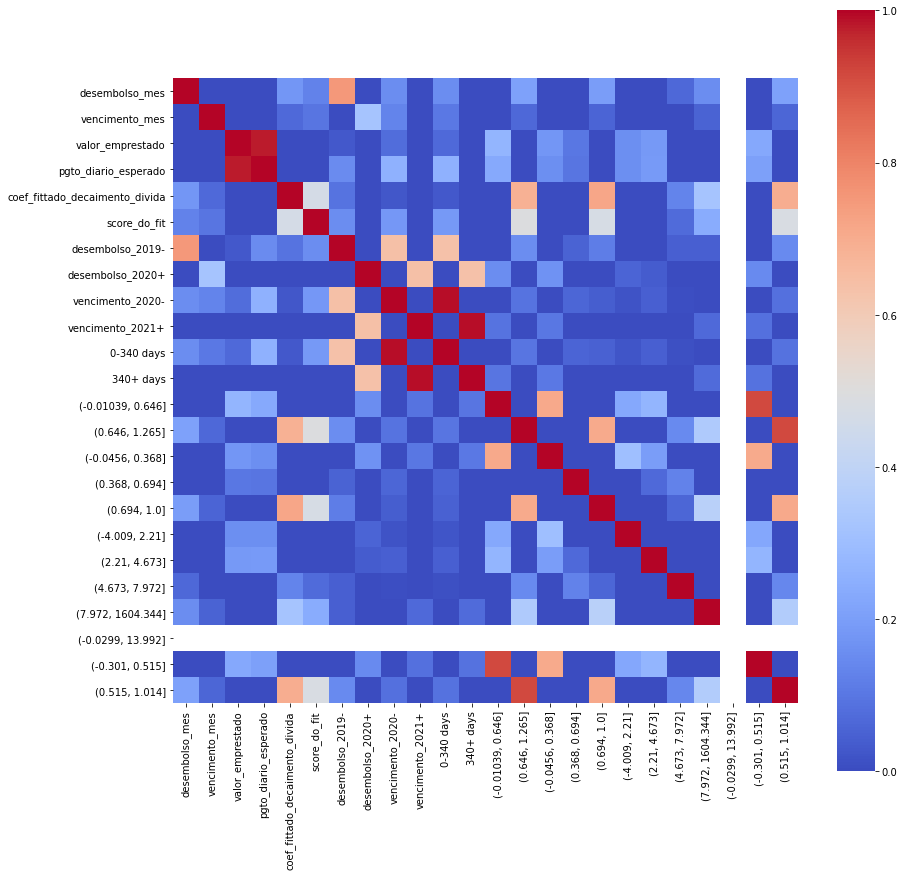

In [90]:
corr_array = X.corr()

fig, ax = plt.subplots(figsize=(14,14))
sns.heatmap(ax=ax, data=corr_array, vmin=0, vmax=1, square=True, cmap='coolwarm')

## Dealing  with Unbalanced Data

768 Defaults (4.43%), 16576 not Default (95.57%).


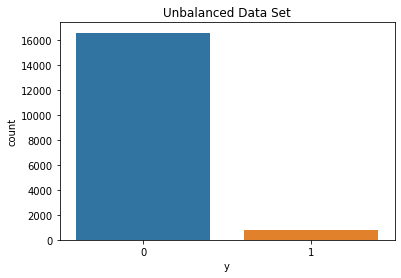

In [91]:
sns.countplot(x=y['y'])

plt.title("Unbalanced Data Set")

n_defaults = sum(y.values.flatten() == 1)
n_not_defaults = sum(y.values.flatten() == 0)

print(f"{n_defaults} Defaults ({n_defaults *100 / y.size:.2f}%), {n_not_defaults} not Default ({n_not_defaults*100 / y.size:.2f}%).")

## Conserving original data for testing

In [92]:
X_values = X.values
y_values = y.values

In [93]:
# setting StratifiedKFold object with 5 splits, 80% for trainning 20% for testing
stratified_kfold = StratifiedKFold(n_splits=5)

for train_idx, test_idx in stratified_kfold.split(X_values, y_values):
    print('train -  {}   |   test -  {}'.format(np.bincount(
        y_values[train_idx].flatten()), np.bincount(y_values[test_idx].flatten())))
        
    # original data set split with StratifiedKFold. 20% for testing
    X_train_original, X_test_original = X_values[train_idx], X_values[test_idx]
    y_train_original, y_test_original = y_values[train_idx], y_values[test_idx]

train -  [13260   615]   |   test -  [3316  153]
train -  [13261   614]   |   test -  [3315  154]
train -  [13261   614]   |   test -  [3315  154]
train -  [13261   614]   |   test -  [3315  154]
train -  [13261   615]   |   test -  [3315  153]


## Undersampling the data

In [94]:
X_train_original.shape

(13876, 24)

In [95]:
y_train_original.shape

(13876, 1)

In [96]:
pd.DataFrame(data=np.c_[X_train_original, y_train_original], columns=list(X.columns) + ['y'])

,desembolso_mes,vencimento_mes,valor_emprestado,pgto_diario_esperado,coef_fittado_decaimento_divida,score_do_fit,desembolso_2019-,desembolso_2020+,vencimento_2020-,vencimento_2021+,...,"(0.368, 0.694]","(0.694, 1.0]","(-4.009, 2.21]","(2.21, 4.673]","(4.673, 7.972]","(7.972, 1604.344]","(-0.0299, 13.992]","(-0.301, 0.515]","(0.515, 1.014]",y
0,3.0,12.0,0.066692,0.179399,-1.223311,-0.809866,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
1,3.0,12.0,0.040760,0.153285,0.172768,0.677593,1.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,3.0,12.0,1.690719,1.682665,-0.562463,-1.380952,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,3.0,12.0,-0.409795,-0.337149,-1.129230,-0.646206,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,3.0,12.0,0.140320,0.184788,0.107358,0.363360,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13871,6.0,9.0,0.524664,0.365072,-0.662905,-0.233560,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
13872,6.0,9.0,-0.330988,-0.608200,0.264828,0.386856,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
13873,6.0,9.0,-0.388439,-0.609222,-1.068891,-0.294026,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
13874,6.0,9.0,-1.546774,-1.720867,-0.404621,1.275611,0.0,1.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [97]:
df = pd.DataFrame(data=np.c_[X_train_original, y_train_original], columns=list(X.columns) + ['y'])

# shuffling the dataset
df_sampled = df.sample(n=df.shape[0], random_state=1)

# default samples
default_df = df_sampled.loc[df['y'] == 1]

#number of default loans
default_amount = default_df.shape[0]

# select same number of non defaults
non_default_df = df_sampled.loc[df['y'] == 0][:default_amount]

balanced_df = pd.concat([default_df, non_default_df])

# Shuffle dataframe rows
balanced_df = balanced_df.sample(n=balanced_df.shape[0], random_state=1)

615 Defaults (50.00%), 615 not Default (50.00%).


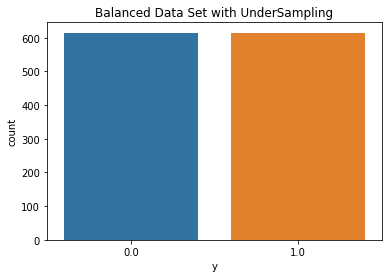

In [98]:
sns.countplot(x=balanced_df['y'])

plt.title("Balanced Data Set with UnderSampling")

n_defaults = sum(balanced_df['y'].values.flatten() == 1)
n_not_defaults = sum(balanced_df['y'].values.flatten() == 0)

print(f"{n_defaults} Defaults ({n_defaults *100 / balanced_df['y'].size:.2f}%), {n_not_defaults} not Default ({n_not_defaults*100 / balanced_df['y'].size:.2f}%).")

In [99]:
from sklearn.model_selection import train_test_split

X_undersampled = balanced_df.drop('y', axis=1)
y_undersampled = balanced_df['y']

X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.25, random_state=1)

## ML MODELS

## Functions

In [100]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, roc_curve
from sklearn.model_selection import GridSearchCV, learning_curve, cross_val_predict, cross_val_score, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

def score_with_original_data(y_true, y_pred):
    
    print(classification_report(y_true, y_pred))
    fig, ax = plt.subplots()
    sns.heatmap(confusion_matrix(y_true, y_pred), ax=ax, annot=True, fmt="d", cmap="Blues")
    ax.set(title="Confusion Matrix", xlabel="Predicted", ylabel="Actual")
    
def roc_graph_auc_score(y_original, y_prob):
    fpr, tpr, thresholds = roc_curve(y_original,
                                     y_prob[:,1],
                                     pos_label=1)

    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # calculate AUC
    auc = roc_auc_score(y_original, y_prob[:,1])
    print(f'AUC: {auc:.2f}')
    
def feature_importance(importance, columns):
    features_idx = np.argsort(- importance )
    
    df = pd.DataFrame(0, index=[0], columns=columns[features_idx])
    df.loc[0, columns[features_idx]] = importance[features_idx]

    fig, ax = plt.subplots(figsize=(16,6))
    g = sns.barplot(ax=ax, data=df)
    plt.xticks(rotation=90);
    
def plot_learning_curve(model, X_train, y_train):
    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(model, X_train, y_train, cv=5, n_jobs=-1,
                       train_sizes=np.linspace(0.1,1.0,9), return_times=True)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    fig, ax = plt.subplots()

    ax.grid()
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    ax.legend(loc="best")

In [101]:
# Logistic Regression
log_reg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'max_iter': [500], 'penalty': ['l1', 'l2']}

log_grid_search = GridSearchCV(
    LogisticRegression(), log_reg_params,
    refit=True, n_jobs=-1, cv=5)

log_grid_search.fit(X_train, y_train)
log_reg = log_grid_search.best_estimator_

0.39869281045751637
0.6966314731020613
0.5258620689655172
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3315
           1       0.77      0.40      0.53       153

    accuracy                           0.97      3468
   macro avg       0.87      0.70      0.75      3468
weighted avg       0.96      0.97      0.96      3468



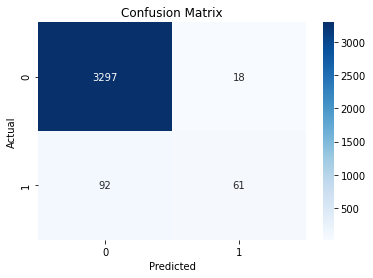

In [103]:
y_prob = log_reg.predict_proba(X_test_original)
y_pred = log_reg.predict(X_test_original)

print(recall_score(y_test_original, y_pred))
print(roc_auc_score(y_test_original, y_pred))
print(f1_score(y_test_original, y_pred))

score_with_original_data(y_test_original, y_pred)

AUC: 0.91


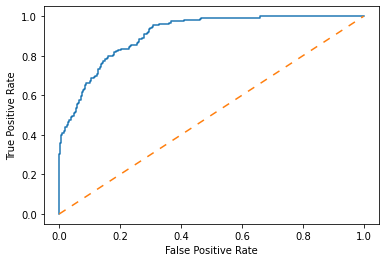

In [104]:
y_prob = log_reg.predict_proba(X_test_original)
roc_graph_auc_score(y_test_original, y_prob)

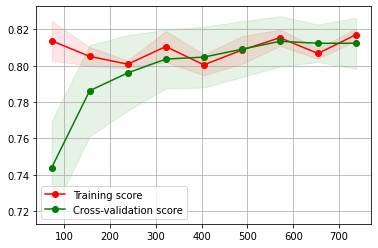

In [105]:
plot_learning_curve(log_reg, X_train, y_train)

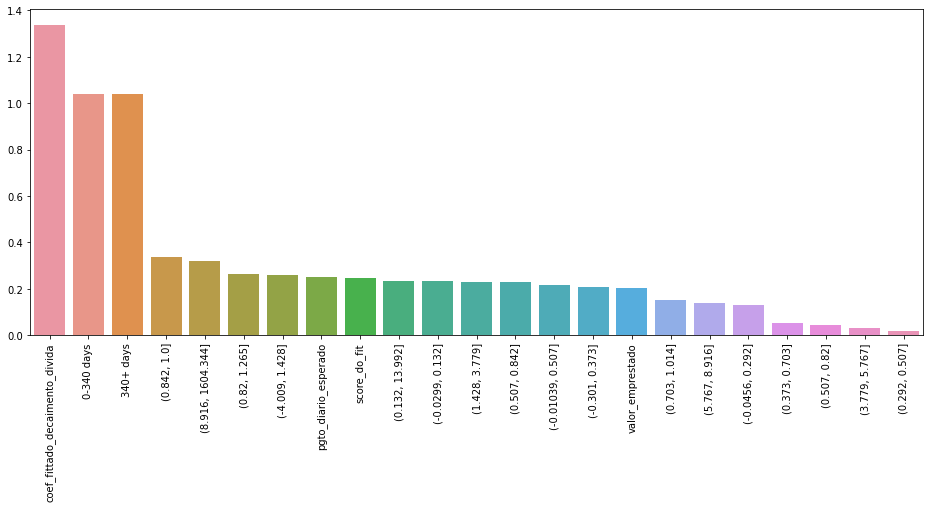

In [37]:
importance = abs(log_reg.coef_[0])
columns = X.columns

feature_importance(importance, columns)

In [38]:
#Random Forest
rf_params = {
    "n_estimators": [50, 70, 90, 110, 140], 
    "max_depth": [12, 14, 16, 20], 
    "max_features": [0.1, 0.2, 0.3, 0.5],
}

rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state = 1), 
    rf_params, n_jobs=-1
)

rf_grid_search.fit(X_train, y_train)
rf_best = rf_grid_search.best_estimator_

0.43790849673202614
0.7162393162393162
0.5630252100840335
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3315
           1       0.79      0.44      0.56       153

    accuracy                           0.97      3468
   macro avg       0.88      0.72      0.77      3468
weighted avg       0.97      0.97      0.97      3468



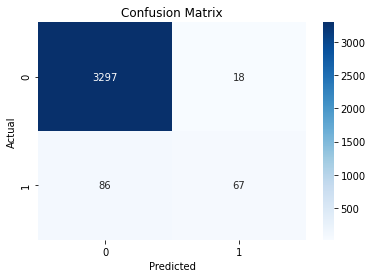

In [39]:
y_pred = rf_best.predict(X_test_original)

print(recall_score(y_test_original, y_pred))
print(roc_auc_score(y_test_original, y_pred))
print(f1_score(y_test_original, y_pred))

score_with_original_data(y_test_original, y_pred)

AUC: 0.92


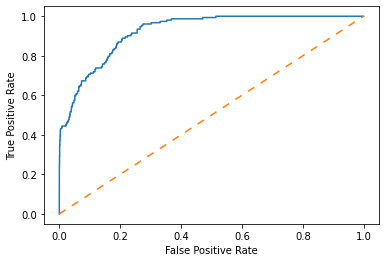

In [90]:
y_prob = rf_best.predict_proba(X_test_original)
roc_graph_auc_score(y_test_original, y_prob)

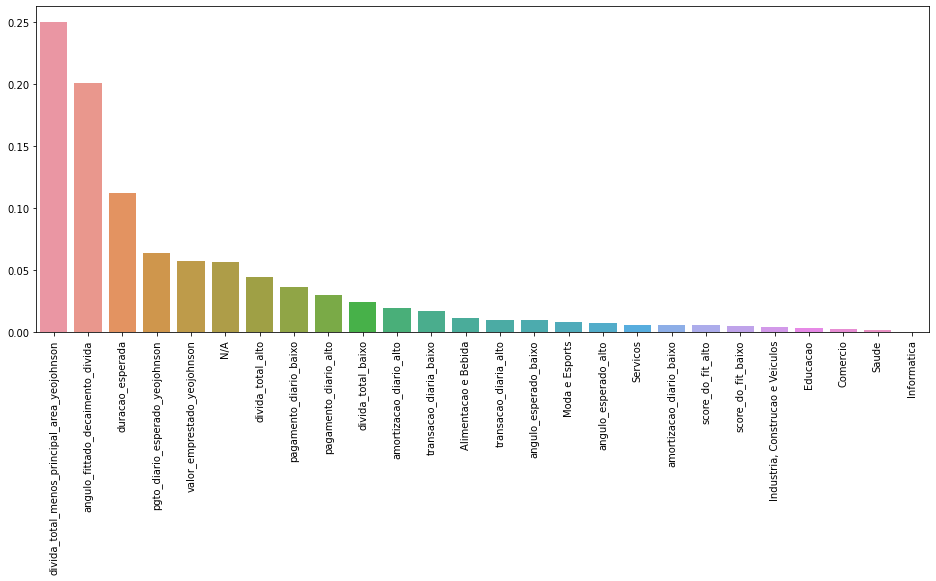

In [91]:
importance = rf_best.feature_importances_
columns = X_original.columns

feature_importance(importance, columns)

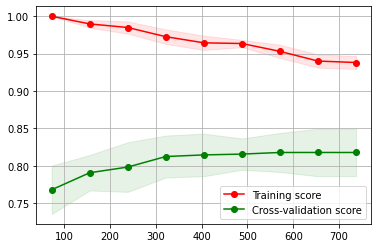

In [92]:
plot_learning_curve(rf_best, X_train, y_train)

# Producing Final results  - Using Logistic Regression with 0.3 of Threshold

In [68]:
chosen_model = log_reg

test = pd.read_parquet("../data/test.parquet")
test.reset_index(drop=True, inplace=True)

X = pipeline.fit_transform(test)

In [73]:
threshold = 0.3

y_prob = log_reg.predict_proba(X)
y_pred = y_prob[:,1] > threshold
y_pred = y_pred.astype(int)

In [84]:
df_test = pd.DataFrame()

In [90]:
df_test['id'] = X.index
df_test['ypred'] = y_pred
df_test['yprob_0'] = y_prob[:,0]
df_test['yprob_1'] = y_prob[:,1]

In [92]:
df_test.to_parquet("../data/submission.parquet")